In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

C:\Users\Louis\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#scrape main epl page
base_url = 'https://understat.com/league/EPL/'
url = base_url

In [3]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [4]:
#get only the teamsData
strings = scripts[2].string

In [5]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

In [6]:
#convert string to json format
data = json.loads(json_data)

In [7]:
# Get teams and their relevant ids and put them into separate dictionary
teams = {}
for id in data.keys():
  teams[id] = data[id]['title']

# EDA to get a feeling of how the JSON is structured
# Column names are all the same, so we just use first element
columns = []
# Check the sample of values per each column
values = []
for id in data.keys():
  columns = list(data[id]['history'][0].keys())
  values = list(data[id]['history'][0].values())
  break

print(columns)
print(values)

['h_a', 'xG', 'xGA', 'npxG', 'npxGA', 'ppda', 'ppda_allowed', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'result', 'date', 'wins', 'draws', 'loses', 'pts', 'npxGD']
['a', 2.6703, 2.8047, 2.6703, 2.04353, {'att': 260, 'def': 23}, {'att': 224, 'def': 24}, 8, 5, 2, 1, 1.2989000000000002, 'w', '2024-08-17 16:30:00', 1, 0, 0, 3, 0.62677]


In [8]:
# Getting data for all teams
dataframes = {}
for id, team in teams.items():
  teams_data = []
  for row in data[id]['history']:
    teams_data.append(list(row.values()))
    
  df = pd.DataFrame(teams_data, columns=columns)
  dataframes[team] = df
  print('Added data for {}.'.format(team))

Added data for Aston Villa.
Added data for Everton.
Added data for Bournemouth.
Added data for Southampton.
Added data for Leicester.
Added data for Crystal Palace.
Added data for Chelsea.
Added data for West Ham.
Added data for Tottenham.
Added data for Arsenal.
Added data for Newcastle United.
Added data for Liverpool.
Added data for Manchester City.
Added data for Manchester United.
Added data for Brighton.
Added data for Fulham.
Added data for Wolverhampton Wanderers.
Added data for Brentford.
Added data for Nottingham Forest.
Added data for Ipswich.


In [9]:
#convert ppda and oppda
for team, df in dataframes.items():
  dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
  dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

#columns to sum and to mean    
cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
cols_to_mean = ['ppda_coef', 'oppda_coef']

frames = []
for team, df in dataframes.items():
  sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
  mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
  final_df = sum_data.join(mean_data)
  final_df['team'] = team
  final_df['matches'] = len(df)
  frames.append(final_df)
  
full_stat = pd.concat(frames)

#reorder columns
full_stat = full_stat[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
full_stat.sort_values('pts', ascending=False, inplace=True)
full_stat.reset_index(inplace=True, drop=True)
full_stat['position'] = range(1,len(full_stat)+1)

full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored']
full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed']
full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts']

#convert floats to integers
cols_to_int = ['wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'deep', 'deep_allowed']
full_stat[cols_to_int] = full_stat[cols_to_int].astype(int)

col_order = ['position','team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
full_stat = full_stat[col_order]
pd.options.display.float_format = '{:,.2f}'.format
full_stat

,position,team,matches,wins,draws,loses,scored,missed,pts,xG,...,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,1,Manchester City,4,4,0,0,11,3,12,9.00,...,3.54,0.54,3.54,4.70,12.93,18.12,68,20,8.68,-3.32
1,2,Newcastle United,4,3,1,0,6,3,10,5.40,...,7.59,4.59,7.59,-2.20,11.61,6.72,28,36,3.92,-6.08
2,3,Arsenal,4,3,1,0,6,1,10,6.58,...,4.50,3.50,4.50,2.08,9.11,10.90,33,21,7.12,-2.88
3,4,Liverpool,4,3,0,1,7,1,9,9.92,...,2.89,1.89,2.89,7.03,8.57,20.18,49,14,9.39,0.39
4,5,Aston Villa,4,3,0,1,7,6,9,9.31,...,5.85,-0.15,5.08,4.23,11.08,9.48,26,21,7.74,-1.26
5,6,Brighton,4,2,2,0,6,2,8,7.51,...,4.83,2.83,4.83,2.68,8.47,14.77,33,19,7.78,-0.22
6,7,Nottingham Forest,4,2,2,0,4,2,8,6.11,...,4.23,2.23,4.23,1.88,12.68,7.06,32,18,6.26,-1.74
7,8,Chelsea,4,2,1,1,8,5,7,7.00,...,5.60,0.60,4.83,2.17,9.51,15.14,27,29,6.03,-0.97
8,9,Manchester United,4,2,0,2,5,5,6,7.86,...,6.02,1.02,5.21,2.65,11.75,11.47,38,25,6.76,0.76
9,10,Brentford,4,2,0,2,6,6,6,6.75,...,7.07,1.07,7.07,-0.31,20.97,10.61,24,61,5.35,-0.65


In [10]:
prem=full_stat[['team','matches','scored','missed','npxG','npxGA']]
prem.head()

,team,matches,scored,missed,npxG,npxGA
0,Manchester City,4,11,3,8.24,3.54
1,Newcastle United,4,6,3,5.40,7.59
2,Arsenal,4,6,1,6.58,4.50
3,Liverpool,4,7,1,9.92,2.89
4,Aston Villa,4,7,6,9.31,5.08


In [11]:
prem = prem.astype({"npxG": float, "scored": float, "missed":float, "npxGA": float, "matches": float})

In [12]:
prem['npxG90']= prem['npxG']/prem['matches']
prem['npxGA90']= prem['npxGA']/prem['matches']
prem.head()

,team,matches,scored,missed,npxG,npxGA,npxG90,npxGA90
0,Manchester City,4.00,11.00,3.00,8.24,3.54,2.06,0.88
1,Newcastle United,4.00,6.00,3.00,5.40,7.59,1.35,1.90
2,Arsenal,4.00,6.00,1.00,6.58,4.50,1.65,1.13
3,Liverpool,4.00,7.00,1.00,9.92,2.89,2.48,0.72
4,Aston Villa,4.00,7.00,6.00,9.31,5.08,2.33,1.27


In [13]:
prem['G90']= prem['scored']/prem['matches']
prem['GA90']= prem['missed']/prem['matches']
prem.head()

,team,matches,scored,missed,npxG,npxGA,npxG90,npxGA90,G90,GA90
0,Manchester City,4.00,11.00,3.00,8.24,3.54,2.06,0.88,2.75,0.75
1,Newcastle United,4.00,6.00,3.00,5.40,7.59,1.35,1.90,1.50,0.75
2,Arsenal,4.00,6.00,1.00,6.58,4.50,1.65,1.13,1.50,0.25
3,Liverpool,4.00,7.00,1.00,9.92,2.89,2.48,0.72,1.75,0.25
4,Aston Villa,4.00,7.00,6.00,9.31,5.08,2.33,1.27,1.75,1.50


In [14]:
prem['adj90']= prem['npxG90']*0.70 + (prem['G90']*0.30)
prem['adjA90']= prem['npxGA90']*0.70 + (prem['GA90']*0.30)
prem.head()

,team,matches,scored,missed,npxG,npxGA,npxG90,npxGA90,G90,GA90,adj90,adjA90
0,Manchester City,4.00,11.00,3.00,8.24,3.54,2.06,0.88,2.75,0.75,2.27,0.84
1,Newcastle United,4.00,6.00,3.00,5.40,7.59,1.35,1.90,1.50,0.75,1.39,1.55
2,Arsenal,4.00,6.00,1.00,6.58,4.50,1.65,1.13,1.50,0.25,1.60,0.86
3,Liverpool,4.00,7.00,1.00,9.92,2.89,2.48,0.72,1.75,0.25,2.26,0.58
4,Aston Villa,4.00,7.00,6.00,9.31,5.08,2.33,1.27,1.75,1.50,2.15,1.34


In [15]:
#prem.to_csv("C:/Users/Louis/OneDrive/Documents/Python/adj-scatter.csv")

In [16]:
prem['path'] = prem['team'] + '.png'
prem

,team,matches,scored,missed,npxG,npxGA,npxG90,npxGA90,G90,GA90,adj90,adjA90,path
0,Manchester City,4.00,11.00,3.00,8.24,3.54,2.06,0.88,2.75,0.75,2.27,0.84,Manchester City.png
1,Newcastle United,4.00,6.00,3.00,5.40,7.59,1.35,1.90,1.50,0.75,1.39,1.55,Newcastle United.png
2,Arsenal,4.00,6.00,1.00,6.58,4.50,1.65,1.13,1.50,0.25,1.60,0.86,Arsenal.png
3,Liverpool,4.00,7.00,1.00,9.92,2.89,2.48,0.72,1.75,0.25,2.26,0.58,Liverpool.png
4,Aston Villa,4.00,7.00,6.00,9.31,5.08,2.33,1.27,1.75,1.50,2.15,1.34,Aston Villa.png
5,Brighton,4.00,6.00,2.00,7.51,4.83,1.88,1.21,1.50,0.50,1.76,1.00,Brighton.png
6,Nottingham Forest,4.00,4.00,2.00,6.11,4.23,1.53,1.06,1.00,0.50,1.37,0.89,Nottingham Forest.png
7,Chelsea,4.00,8.00,5.00,7.00,4.83,1.75,1.21,2.00,1.25,1.83,1.22,Chelsea.png
8,Manchester United,4.00,5.00,5.00,7.86,5.21,1.96,1.30,1.25,1.25,1.75,1.29,Manchester United.png
9,Brentford,4.00,6.00,6.00,6.75,7.07,1.69,1.77,1.50,1.50,1.63,1.69,Brentford.png


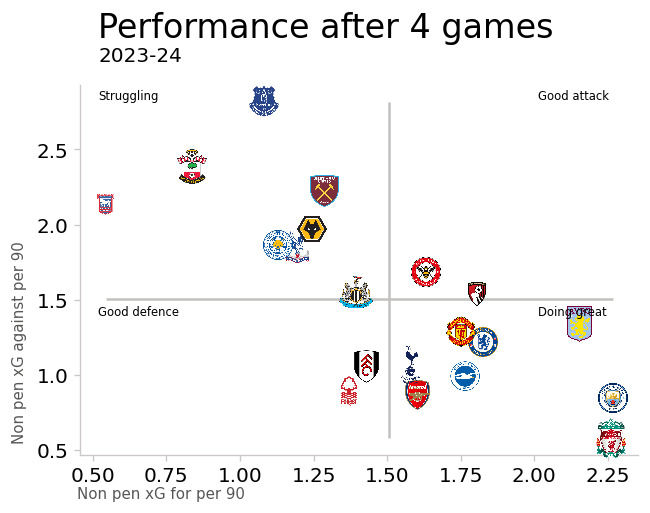

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.scatter(prem['adj90'], prem['adjA90'], color='white')

def getImage(path):
    return OffsetImage(plt.imread("C:/Users/Louis/OneDrive/Documents/Python/images/Scatter/" + path), zoom=.05, alpha = 1)

for index, row in prem.iterrows():
    ab = AnnotationBbox(getImage(row['path']), (row['adj90'], row['adjA90']), frameon=False)
    ax.add_artist(ab)
    
# Set font and background colour
plt.rcParams.update({'font.family':'sans-serif'})
bgcol = '#fafafa'

# Change plot spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#ccc8c8')
ax.spines['bottom'].set_color('#ccc8c8')

# Change ticks
plt.tick_params(axis='x', labelsize=12, color='#ccc8c8')
plt.tick_params(axis='y', labelsize=12, color='#ccc8c8')

# Add average lines
plt.hlines(prem['adjA90'].mean(), prem['adj90'].min(), prem['adj90'].max(), color='#c2c1c0')
plt.vlines(prem['adj90'].mean(), prem['adjA90'].min(), prem['adjA90'].max(), color='#c2c1c0')

# Text

## Title & comment
fig.text(.15,.98,'Performance after 4 games',size=20)
fig.text(.15,.93,'2023-24', size=12)

## Avg line explanation
fig.text(.03,.14,'Non pen xG against per 90', size=9, color='#575654',rotation=90)
fig.text(.12,0.02,'Non pen xG for per 90', size=9, color='#575654')

## Axes titles
fig.text(.76,.400,'Doing great', size=7, color='#000000')
fig.text(.76,.850,'Good attack', size=7, color='#000000')
fig.text(.15,.400,'Good defence', size=7, color='#000000')
fig.text(.15,.850,'Struggling', size=7, color='#000000')

## Save plot
plt.savefig('C:/Users/Louis/OneDrive/Documents/Python/images/plots/team-progress.png', dpi=1200, bbox_inches = "tight")